# AGCO Challenge - Forecasting

### Importing libraries

In [341]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from IPython.display import display 
import warnings
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.api as sm
import seaborn as sns

### Loading the dataset

In [342]:
dataset = pd.read_excel('Challenge2  Forecasting.xlsx', sheet_name='Data', header = 1)
dataset = dataset.rename(columns={'Unnamed: 0': 'Year', 'Unnamed: 1': 'Month'})
dataset[['Year', 'Month']] = dataset[['Year', 'Month']].astype('str')
dataset['Month_Year'] = pd.to_datetime(dataset['Month'] + '-' + dataset['Year'])#.dt.strftime('%m/%Y')
# dataset.drop(columns=['Month', 'Year'], inplace=True)

column_names = dataset.columns.tolist()
dataset = dataset[column_names[-1:] + column_names[:-1]]

# dataset.set_index('Month_Year', inplace=True)

display(dataset.head())
print(f'Shape => {dataset.shape}')

,Month_Year,Year,Month,Western European tractor industry >50 HP,Western European tractor industry 80-159 HP,Western European tractor industry >160 HP,France tractor industry >50 HP,German tractor industry >50 HP,Italy tractor industry >50 HP,EU Industry order intake >50 HP,...,Germany Valtra order intake > 50 HP,Italy Industry order intake >50 HP,Italy Fendt order intake > 50 HP,Italy MF order intake > 50 HP,Italy Valtra order intake > 50 HP,Wheat Price,Milk Price EU,Milk Price France,Milk Price Germany,CEMA Business Barometer Index (TR&HV)
0,2010-01-01,2010,1,6187,3731,1407,1425,711,1262,7459.0,...,23.0,928.0,90.0,15.0,6.0,127.60,28.94,30.99,28.40,-51.6
1,2010-02-01,2010,2,6573,4039,1561,1282,949,1398,9634.0,...,24.0,1435.0,71.0,34.0,8.0,124.52,28.63,29.89,28.14,-44.7
2,2010-03-01,2010,3,11810,6612,3486,1998,2458,1771,11269.0,...,41.0,1525.0,80.0,61.0,17.0,122.41,28.13,28.40,27.95,-35.9
3,2010-04-01,2010,4,10354,6026,2911,1547,2333,1537,10124.0,...,52.0,1450.0,92.0,44.0,16.0,128.81,28.18,27.67,28.37,-26.8
4,2010-05-01,2010,5,9686,5835,2256,1307,2172,2027,8584.0,...,34.0,1202.0,94.0,47.0,7.0,134.31,28.73,27.85,29.41,-13.9


Shape => (115, 30)


In [343]:
# Checking if there are any null/missing values
for col in dataset.columns:
    num_nulls = dataset[col].isnull().sum()
    if  num_nulls!= 0: print(f'{col} => {num_nulls}')
# There are very few missng/null values. On careful examination, I saw that these data points are towards the end of the dataset. 
# We'll impute them using forward filling in the Data Preprocessing section. Forward filling simply replaces the missing value with the last non-missing value.

EU Industry order intake >50 HP => 1
EU Fendt order intake > 50 HP  => 1
EU MF order intake > 50 HP  => 1
EU Valtra order intake > 50 HP  => 1
France Industry order intake >50 HP => 1
France Fendt order intake > 50 HP => 1
France MF order intake > 50 HP => 2
France Valtra order intake > 50 HP => 1
Germany Industry order intake >50 HP => 1
Germany Fendt order intake > 50 HP => 1
Germany MF order intake > 50 HP => 3
Germany Valtra order intake > 50 HP => 1
Italy Industry order intake >50 HP => 1
Italy Fendt order intake > 50 HP => 1
Italy MF order intake > 50 HP => 2
Italy Valtra order intake > 50 HP => 1
Milk Price France => 1
Milk Price Germany => 1


### Exploratory Data Analysis

In [344]:
# Plotting the target variable (column E) to gauge the trend and seasonality
fig = px.line(dataset, x="Month_Year", y = 'Western European tractor industry >160 HP ',
              hover_data={"Month_Year": "|%B %d, %Y"},
              title='Industry Demand')
fig.show()

#### In the above plot, we can't really a clear increasing/decreasing trend. This might indicate that the market share isn't growing over time. 
#### There seems to be a yearly seasonality since we can see a repeating cyclic pattern. This is in alignment with our common understanding of farming seasons since they repeat every year. 
#### We'll make use of this information in choosing a forecasting algorithm and its parameters.

In [345]:
# Does demand change from month to month?

temp_df = dataset[['Month', 'Western European tractor industry >160 HP ']]
temp_df['Month'] = temp_df['Month'].astype('int64')
temp_df = temp_df.groupby('Month').mean().sort_values('Month').reset_index()
fig1 = px.line(temp_df, x = 'Month', y = 'Western European tractor industry >160 HP ')
fig1.show()

#### In the above plot, we can see that the demand is higher for two different times in a year. This again aligns with our common understanding of farming seasons and we expect demand to be higher during planting and harvesting seasons.

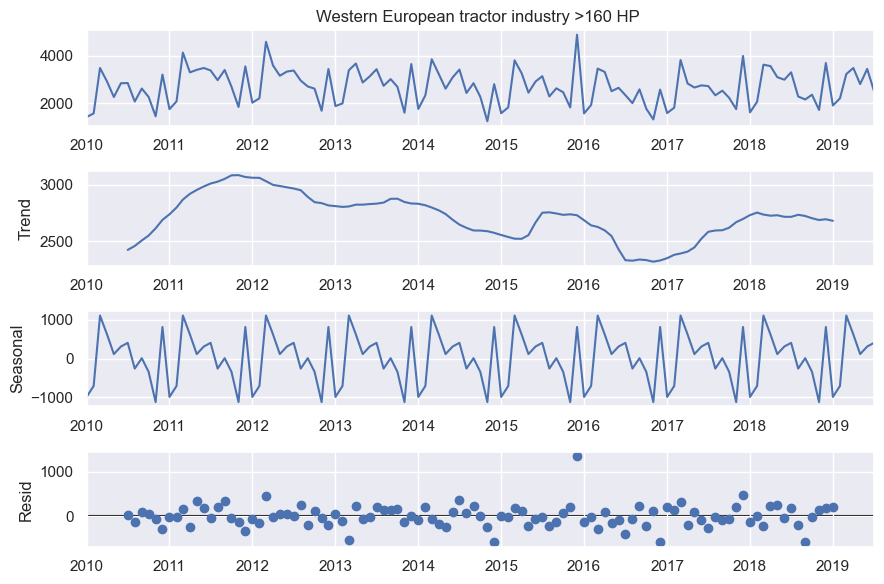

In [346]:
# We can also decompose the time-series into different components such as trend, seasonality, and residuals
temp_df = dataset.set_index('Month_Year')
decomposition_result=seasonal_decompose(temp_df['Western European tractor industry >160 HP '], model='additive', period=12)
decomposition_result.plot()
plt.show()

#### In the above plot, we can see a fluctuating trend and a yearly seasonality. This aligns with our analysis from the previous two plots. In the residual plot, we can see that one data point around 2016 seems very different from others. This might be an outlier and we'll check that next.

In [347]:
# Looking at some basic statistics for the target variable to identify outliers
dataset[["Western European tractor industry >160 HP "]].describe()

,Western European tractor industry >160 HP
count,115.000000
mean,2699.147826
std,751.328370
min,1227.000000
25%,2111.500000
50%,2694.000000
75%,3311.500000
max,4897.000000


In [348]:
# Box plot to see if there are any outliers
box_fig = px.box(dataset, y="Western European tractor industry >160 HP ")
box_fig.show()

#### Everything looks alright and there doesn't seem to be any outlier. We'll keep everything in the data and shall move forward.

#### Plotting the target variable against exogenous variable to visualize if there'a any pattern/correlation

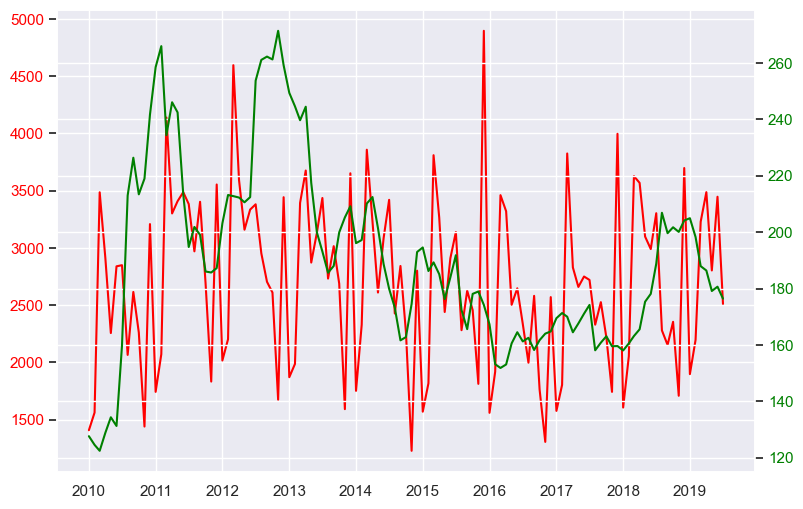

In [349]:
# Target vs exogenous variables - analysis
def plot_target_exog(target, exog):
    fig, ax = plt.subplots()

    # Plot target, and set tick labels to the same color
    ax.plot(target, color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Generate a new Axes instance, on the twin-X axes (same position)
    ax2 = ax.twinx()

    # Plot exog variable and change tick color
    ax2.plot(exog, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.show()

temp_data = dataset[['Month_Year','Western European tractor industry >160 HP ', 'Wheat Price', 'Milk Price EU', 'CEMA Business Barometer Index (TR&HV)']]
temp_data.set_index('Month_Year', inplace=True)

# Target variable vs exogenous variable Wheat Price
plot_target_exog(temp_data['Western European tractor industry >160 HP '], temp_data['Wheat Price'])

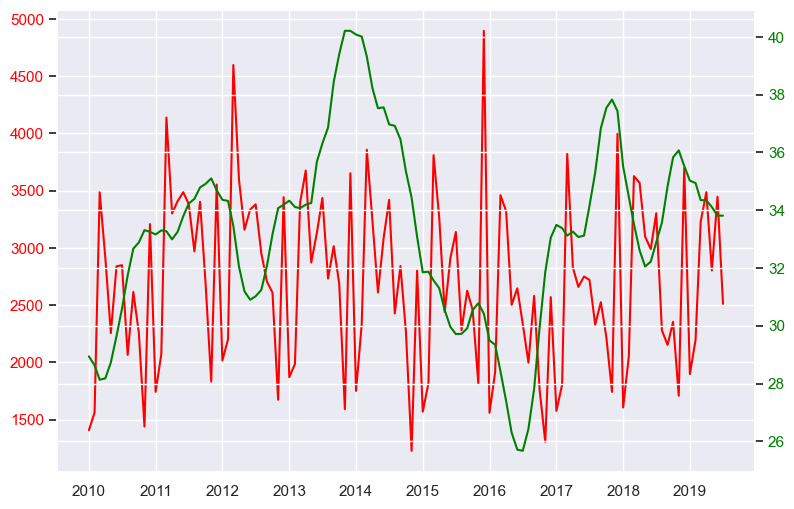

In [350]:
# Target variable vs exogenous variable Milk Price EU
plot_target_exog(temp_data['Western European tractor industry >160 HP '], temp_data['Milk Price EU'])

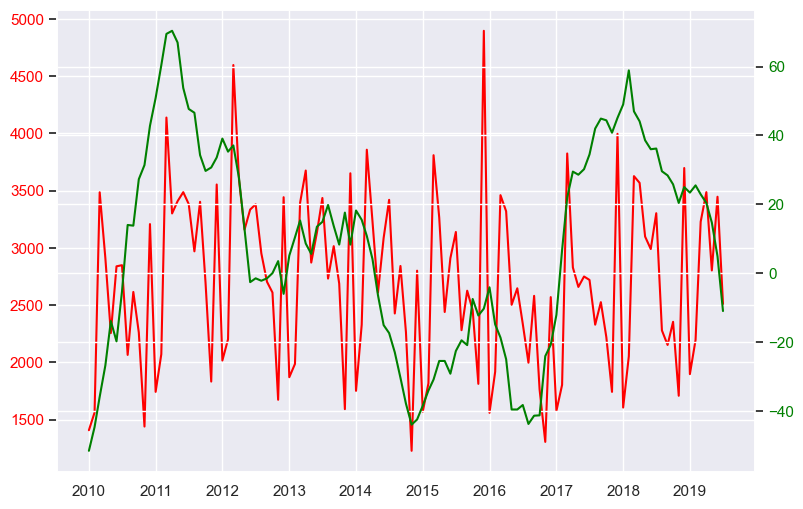

In [351]:
# Target variable vs exogenous variable CEMA Business Barometer Index (TR&HV)
plot_target_exog(temp_data['Western European tractor industry >160 HP '], temp_data['CEMA Business Barometer Index (TR&HV)'])

#### Imputing missing data

In [352]:
# Missing values imputation using forward filling 
dataset.ffill(axis=0, inplace=True)

## Approach 1 - Univariate time series forecasting

### Exponential Smoothing

In [353]:
# Filter the dataset for univariate time series forecasting
dataset_univariate = dataset[['Month_Year', 'Western European tractor industry >160 HP ', 'Wheat Price', 'Milk Price EU','CEMA Business Barometer Index (TR&HV)']]
dataset_univariate.set_index('Month_Year', inplace = True)
dataset_univariate.head()

,Western European tractor industry >160 HP,Wheat Price,Milk Price EU,CEMA Business Barometer Index (TR&HV)
Month_Year,,,,
2010-01-01,1407,127.60,28.94,-51.6
2010-02-01,1561,124.52,28.63,-44.7
2010-03-01,3486,122.41,28.13,-35.9
2010-04-01,2911,128.81,28.18,-26.8
2010-05-01,2256,134.31,28.73,-13.9


In [354]:
# 80-20 split for train and test sets
test_size = 0.2
training_set, testing_set = train_test_split(dataset_univariate, test_size=test_size, shuffle=False)
print(training_set.shape, testing_set.shape)

(92, 4) (23, 4)


In [355]:
# Fit Simple exponential smoothing model and get forecasts
warnings.filterwarnings("ignore")
model_simple = SimpleExpSmoothing(training_set['Western European tractor industry >160 HP ']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(testing_set))

In [356]:
# Fit Holt's model and get forecasts
warnings.filterwarnings("ignore")
model_holt = Holt(training_set['Western European tractor industry >160 HP ']).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(testing_set))

In [357]:
# Fit Holt Winters model and get forecasts
warnings.filterwarnings("ignore")
model_holt_winters = ExponentialSmoothing(training_set['Western European tractor industry >160 HP '], trend=None,
                                          seasonal='add', seasonal_periods=12)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(testing_set))

In [358]:
def plot_results(forecast: pd.Series, title: str, method_name: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=training_set.index, y=training_set['Western European tractor industry >160 HP '], name='Train'))
    fig.add_trace(go.Scatter(x=testing_set.index, y=testing_set['Western European tractor industry >160 HP '], name='Test'))
    fig.add_trace(go.Scatter(x=testing_set.index, y=forecast, name=method_name))
    fig.update_layout(template="simple_white", font=dict(size=15), title_text=title,
                      width=1000, title_x=0.5, height=400, xaxis_title='Month_Year',
                      yaxis_title='Industry Demand')
    return fig.show()

# Plot the forecasts
plot_results(forecasts_simple, "Actuals vs Predictions using Simple Exponential Smoothing", 'Simple Exponential Smoothin')
plot_results(forecasts_holt,  "Actuals vs Predictions using Holt's method", "Holt's method")
plot_results(forecasts_holt_winters,  "Actuals vs Predictions using Holt Winter's method", "Holt Winter's method")


In [359]:
# RMSE and MAPE for these methods
print('RMSE (Simple Exponential Smoothing) => ', mean_squared_error(testing_set['Western European tractor industry >160 HP '], forecasts_simple) ** 0.5)
print("RMSE (Holt's method)=> ", mean_squared_error(testing_set['Western European tractor industry >160 HP '], forecasts_holt) ** 0.5)
print("RMSE (Holt Winter's method)=> ", mean_squared_error(testing_set['Western European tractor industry >160 HP '], forecasts_holt_winters) ** 0.5)

def mape(actual: pd.Series, forecast: pd.Series):
    mape = ((actual - forecast).abs() / actual).mean()
    return mape
print("MAPE (Simple Exponential Smoothing)=> ", mape(testing_set['Western European tractor industry >160 HP '], forecasts_simple))
print("MAPE (Holt's method)=> ", mape(testing_set['Western European tractor industry >160 HP '], forecasts_holt))
print("MAPE (Holt Winter's method)=> ", mape(testing_set['Western European tractor industry >160 HP '], forecasts_holt_winters))

RMSE (Simple Exponential Smoothing) =>  730.1144297764009
RMSE (Holt's method)=>  727.9536949237795
RMSE (Holt Winter's method)=>  418.7486297128626
MAPE (Simple Exponential Smoothing)=>  0.23947604424651187
MAPE (Holt's method)=>  0.23572047221642164
MAPE (Holt Winter's method)=>  0.13926832896077365


#### Holt Winter's method outperforms the other two methods. Why is that so? - Holt Winter's method account for the yearly seasonality which other two methods can't.

In [360]:
# Looking at Holt Winter's model summary to get further insights
print(model_holt_winters.summary())

                                  ExponentialSmoothing Model Results                                  
Dep. Variable:     Western European tractor industry >160 HP    No. Observations:                   92
Model:                                   ExponentialSmoothing   SSE                        7670162.482
Optimized:                                               True   AIC                           1070.457
Trend:                                                   None   BIC                           1105.763
Seasonal:                                            Additive   AICC                          1077.711
Seasonal Periods:                                          12   Date:                 Wed, 01 Mar 2023
Box-Cox:                                                False   Time:                         01:00:18
Box-Cox Coeff.:                                          None                                         
                          coeff                 code              optimiz

#### Smoothing_level, alpha, is close to 0.4 which is relatively high. It means that the level component vary frequently. It indicates a lot of randomness in the data which can't be captured in the seasonality. Smoothing_seasonal (gamma) is close to 0 indicating that seasonality don't vary much over time.

In [361]:
# Walk forward validation - Holt Winter's
# Let's see if using walk-forward validation (instead of a simple train-test split) further improves the model performance.
warnings.filterwarnings("ignore")
temp = training_set['Western European tractor industry >160 HP '] # Initial training set
preds = pd.Series() # Predicted values
preds.index.name = 'Month_Year'

# Predict for one time period at a time and retrain the model after every prediction
for t in range((len(testing_set))):
    model_holt_winters = ExponentialSmoothing(temp, trend=None,
                                          seasonal='add', seasonal_periods=12)\
                                          .fit(optimized=True)
    forecasts_holt_winters = model_holt_winters.forecast()

    y_pred = model_holt_winters.forecast()
    y_pred.index.name = 'Month_Year'
    preds = pd.concat([preds, y_pred])
    temp = pd.concat([temp, testing_set.iloc[t:t+1, 0]])

rmse_wf = (mean_squared_error(testing_set['Western European tractor industry >160 HP '], preds)) ** 0.5
mape_wf = mape(testing_set['Western European tractor industry >160 HP '], preds)
print("RMSE for Holt Winter's with walk-forward validation => ", rmse_wf)
print("MAPE for Holt Winter's with walk-forward validation => ", mape_wf)
plot_results(preds,  "Actuals vs Predictions using Holt Winter's method with Walk-forward validation", "Holt Winter's method")

RMSE for Holt Winter's with walk-forward validation =>  370.5151244390883
MAPE for Holt Winter's with walk-forward validation =>  0.11718007158070179


#### We can see a slight improvement in performance using walk-forward validation - RMSE from ~419 to ~371 and MAPE from ~14% to ~ 12%

### ARIMA

In [362]:
# Let's fit an ARIMA model to see if it outperforms the Holt Winter's method
# This function fits an ARIMA (p,d,q) model, evaluates its performance on the test data using walk-forward validation, and returns its RMSE and MAPE
def eval_arima(p = 6, d = 1 , q = 0):
    temp = training_set['Western European tractor industry >160 HP '] # Initial training set
    preds = pd.Series() # Predicted values
    preds.index.name = 'Month_Year'

    # Predict for one time period at a time and retrain the model after every prediction
    for t in range((len(testing_set))):
            model = ARIMA(temp, order=(p,d,q))
            model_fit = model.fit()

            y_pred = model_fit.forecast()
            y_pred.index.name = 'Month_Year'
            preds = pd.concat([preds, y_pred])
            temp = pd.concat([temp, testing_set.iloc[t:t+1, 0]])
    rmse = (mean_squared_error(testing_set['Western European tractor industry >160 HP '], preds)) ** 0.5
    mape_ = mape(testing_set['Western European tractor industry >160 HP '], preds)
    return rmse, mape_, preds

In [363]:
# This function evaluates combinations of p, d and q values for an ARIMA model to find the best (p,d,q) combination
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg, best_mape, best_cfg_mape = float("inf"), None, float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    rmse, mape, _ = eval_arima(p, d, q)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, (p, d, q)
                    if mape < best_mape:
                        best_mape, best_cfg_mape = mape, (p, d, q)

                    # print('ARIMA%s RMSE=%.3f' % ((p, d, q),rmse))
                    # print('ARIMA%s MAPE=%.3f' % ((p, d, q),mape))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    print('Best ARIMA%s MAPE=%.3f' % (best_cfg_mape, best_mape))

In [364]:
# # Used this code to find the optimal values of p, d, and q
# p_values = [0, 1, 2, 4, 6, 8, 10, 12]
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# evaluate_models(p_values, d_values, q_values)

In [365]:
warnings.filterwarnings("ignore")
rmse_arima, mape_arima, preds_arima = eval_arima(12, 0, 0)
print("RMSE for ARIMA (12, 0, 0) with walk-forward validation => ", rmse_arima)
print("MAPE for ARIMA (12, 0, 0) with walk-forward validation => ", mape_arima)
plot_results(preds_arima,  "Actuals vs Predictions using ARIMA (12, 0, 0) with Walk-forward validation", "ARIMA (12, 0, 0)")

RMSE for ARIMA (12, 0, 0) with walk-forward validation =>  463.1000125250135
MAPE for ARIMA (12, 0, 0) with walk-forward validation =>  0.12627257372222347


#### ARIMA performs slightly worse than Holt Winter's method

### Seasonal ARIMA with exogenous variables

In [366]:
## Used this code to find the optimal values of order (p, d, q) and seasonal order (P, D, Q, m)
# Let's see if SARIMAX (Seasonal ARIMA with exogenous variables) performs better than ARIMA (12, 0, 0) and Holt Winter's
# First, We'll use auto_arima to find the optimal value of parameters p, d, q, P, D, Q for SARIMAX model
# warnings.filterwarnings("ignore")
# sxmodel = auto_arima(dataset_univariate[['Western European tractor industry >160 HP ']], dataset_univariate[['Wheat Price', 'Milk Price EU', 'CEMA Business Barometer Index (TR&HV)']],
#                            start_p=1, start_q=1,
#                            test='adf',
#                            max_p=12, max_q=3, m=12,
#                            start_P=0, seasonal=True, information_criterion='oob',
#                            d=None, D=None, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=False, out_of_sample_size = 23, maxiter=1000)

In [367]:
# Data preparation for SARIMAX
endog_train_sx = training_set[['Western European tractor industry >160 HP ']]
exog_train_sx = training_set[['Wheat Price', 'Milk Price EU', 'CEMA Business Barometer Index (TR&HV)']]
endog_test_sx = testing_set[['Western European tractor industry >160 HP ']]
exog_test_sx = testing_set[['Wheat Price', 'Milk Price EU', 'CEMA Business Barometer Index (TR&HV)']]

preds_sarimax = pd.Series() # Predicted values
preds_sarimax.index.name = 'Month_Year'

# Predict for one time period at a time and retrain the model after every prediction - Walk-forward validation
for t in range((len(exog_test_sx))):
        sxmodel = SARIMAX(endog_train_sx, exog_train_sx, order = (0, 0, 0), seasonal_order=(2,0,1, 12), trend='n').fit(disp=False)

        y_pred = sxmodel.forecast(exog = exog_test_sx.iloc[t:t+1,:])
        y_pred.index.name = 'Month_Year'
        preds_sarimax = pd.concat([preds_sarimax, y_pred])
        endog_train_sx = pd.concat([endog_train_sx, endog_test_sx.iloc[t:t+1, 0].to_frame()])
        exog_train_sx = pd.concat([exog_train_sx, exog_test_sx.iloc[t:t+1, :]])

In [368]:
# Forecasting results using SARIMAX model
rmse_sarimax = (mean_squared_error(endog_test_sx.squeeze(), preds_sarimax)) ** 0.5
mape_sarimax = mape(endog_test_sx.squeeze(), preds_sarimax)
print("RMSE with SARIMAX => ", rmse_sarimax)
print("MAPE with SARIMAX => ", mape_sarimax)
plot_results(preds_sarimax,  "Actuals vs Predictions using SARIMAX", "SARIMAX")

RMSE with SARIMAX =>  330.5751102505372
MAPE with SARIMAX =>  0.09798046076675057


#### SARIMAX outperforms Holt Winter's and ARIMA, with the RMSE of ~331 and MAPE of ~10%

In [369]:
sxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     Western European tractor industry >160 HP    No. Observations:                  114
Model:                                 SARIMAX(2, 0, [1], 12)   Log Likelihood                -844.616
Date:                                        Wed, 01 Mar 2023   AIC                           1703.233
Time:                                                01:00:39   BIC                           1722.386
Sample:                                            01-01-2010   HQIC                          1711.006
                                                 - 06-01-2019                                         
Covariance Type:                                          opg                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Wheat Price                               4.2590      1.401      3.039      0.002       1.512       7.006
Milk Price EU                            43.4684     10.186      4.268      0.000      23.505      63.432
CEMA Business Barometer Index (TR&HV)     0.2710      0.503      0.538      0.590      -0.716       1.258
ar.S.L12                                  0.7570      0.122      6.191      0.000       0.517       0.997
ar.S.L24                                  0.2425      0.122      1.996      0.046       0.004       0.481
ma.S.L12                                 -0.9244      0.117     -7.877      0.000      -1.154      -0.694
sigma2                                 1.115e+05      0.000   4.89e+08      0.000    1.11e+05    1.11e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.51   Jarque-Bera (JB):               186.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             1.10
Prob(H) (two-sided):                  0.56   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+25. Standard errors may be unstable.
"""

#### From the model summary above, we can see that there's a positive correlation between 'Western European tractor industry >160 HP ' and exogenous variables (Wheat Price, Milk Price EU, CEMA Business Barometer Index (TR&HV)).
#### Wheat Price and Milk Price EU are statistically significant since the p-value is small (less than 0.05)
#### However, CEMA Business Barometer Index (TR&HV)	is not statistically significant and has a large p-value

## Approach 2 - Multivariate Time series forecasting using VARMAX (including exogenous variables)

In [370]:
# Data preparation for VARMAX
dataset_multivariate = dataset.drop(['Month', 'Year'], axis = 1)
dataset_multivariate.set_index('Month_Year', inplace=True)

endog = dataset_multivariate.iloc[:,:22]
exog = dataset_multivariate.iloc[:,22:]

endog_train, endog_test, exog_train, exog_test = train_test_split(endog, exog, test_size=test_size, shuffle=False)
print(endog_train.shape, endog_test.shape, exog_train.shape, exog_test.shape )

(92, 22) (23, 22) (92, 5) (23, 5)


In [371]:
# Fitting model
model_varmax = VARMAX(endog_train, exog_train, order = (1,1), trend = 'n')
fit_model_varmax = model_varmax.fit(disp=False)

In [372]:
# Forecasting results using VARMAX model
preds_varmax = fit_model_varmax.forecast(exog = exog_test, steps=23)['Western European tractor industry >160 HP ']
rmse_varmax = (mean_squared_error(endog_test['Western European tractor industry >160 HP '], preds_varmax)) ** 0.5
mape_varmax = mape(endog_test['Western European tractor industry >160 HP '], preds_varmax)
print("RMSE for VARMAX => ", rmse_varmax)
print("MAPE for VARMAX => ", mape_varmax)
plot_results(preds_varmax,  "Actuals vs Predictions using VARMAX", "VARMAX")

RMSE for VARMAX =>  719.4869445221302
MAPE for VARMAX =>  0.2574981028998467


#### VARMAX (with exogenous variables) doesn't perform so great since it doesn't account for seasonality. There's a way to include seasonality in this model but it isn't implemented in any python library yet. So, I decided to explore other advanced/promising methods such as regression and fbprohet rather than spending more time on seasonal VARMAX.

## Approach 3 - Multivariate time series forecasting using Regression

In [373]:
# Data preparation for regression
exog_cols = dataset.columns.tolist()[-5:]
endog_cols = dataset.columns.tolist()[3:-5]
endog_cols.remove('Western European tractor industry >160 HP ')

dataset_regression = dataset.copy()
# Lag endog columns by a year - The idea is to use last year, current month data to predict last year, current month
dataset_regression[endog_cols] = dataset_regression[endog_cols].shift(12)
dataset_regression.dropna(inplace=True)
dataset_regression.reset_index(drop=True, inplace=True)
dataset_regression.head()

,Month_Year,Year,Month,Western European tractor industry >50 HP,Western European tractor industry 80-159 HP,Western European tractor industry >160 HP,France tractor industry >50 HP,German tractor industry >50 HP,Italy tractor industry >50 HP,EU Industry order intake >50 HP,...,Germany Valtra order intake > 50 HP,Italy Industry order intake >50 HP,Italy Fendt order intake > 50 HP,Italy MF order intake > 50 HP,Italy Valtra order intake > 50 HP,Wheat Price,Milk Price EU,Milk Price France,Milk Price Germany,CEMA Business Barometer Index (TR&HV)
0,2011-01-01,2011,1,6187.0,3731.0,1742,1425.0,711.0,1262.0,7459.0,...,23.0,928.0,90.0,15.0,6.0,258.55,33.16,33.20,33.12,50.9
1,2011-02-01,2011,2,6573.0,4039.0,2071,1282.0,949.0,1398.0,9634.0,...,24.0,1435.0,71.0,34.0,8.0,266.00,33.30,33.06,33.20,60.4
2,2011-03-01,2011,3,11810.0,6612.0,4139,1998.0,2458.0,1771.0,11269.0,...,41.0,1525.0,80.0,61.0,17.0,234.41,33.27,32.08,34.06,69.5
3,2011-04-01,2011,4,10354.0,6026.0,3301,1547.0,2333.0,1537.0,10124.0,...,52.0,1450.0,92.0,44.0,16.0,246.09,32.99,30.41,34.20,70.4
4,2011-05-01,2011,5,9686.0,5835.0,3408,1307.0,2172.0,2027.0,8584.0,...,34.0,1202.0,94.0,47.0,7.0,242.50,33.25,30.53,34.44,67.0


In [374]:
# 80-20 train test split
y = dataset_regression[['Western European tractor industry >160 HP ']]
X = dataset_regression.drop(['Month_Year', 'Month', 'Year', 'Western European tractor industry >160 HP '], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [375]:
# Fit the linear regression model
regression_model = LinearRegression().fit(X_train, y_train)

In [376]:
# Forecast results using linear regression
preds_reg = pd.Series(regression_model.predict(X_test).reshape(21,))
print('RMSE for Linear Regression =>', mean_squared_error(y_test.reset_index(drop=True).squeeze(), preds_reg) ** 0.5)
print('MAPE for Linear Regression =>', mape(y_test.reset_index(drop=True).squeeze(), preds_reg))

RMSE for Linear Regression => 485.0915845441958
MAPE for Linear Regression => 0.1307829894139633


#### Linear regression: RMSE ~485, MAPE ~13%

In [377]:
# sklearn's linear regression doesn't provide a model summary. So, looking at statsmodels summary to identify significant factors and other important metrics 
import statsmodels.api as sm

#add constant to predictor variables
X_train = sm.add_constant(X_train)

#fit linear regression model
model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                                        OLS Regression Results                                        
Dep. Variable:     Western European tractor industry >160 HP    R-squared:                       0.830
Model:                                                    OLS   Adj. R-squared:                  0.750
Method:                                         Least Squares   F-statistic:                     10.36
Date:                                        Wed, 01 Mar 2023   Prob (F-statistic):           3.55e-13
Time:                                                01:05:08   Log-Likelihood:                -586.83
No. Observations:                                          82   AIC:                             1228.
Df Residuals:                                              55   BIC:                             1293.
Df Model:                                                  26                                         
Covariance Type:                                    nonrobust            

#### From the model summary, we can see that high multicollinearity is an issue. Using Lasso regression for feature selection next.

In [378]:
# Fitting lasso model for feature selection (also removes high multicollinearity)
X_train.drop('const', axis = 1, inplace = True)
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

# Forecast results using Lasso
preds_lasso = pd.Series(lasso_model.predict(X_test))
print('RMSE for Lasso Regression =>', mean_squared_error(y_test.reset_index(drop=True).squeeze(), preds_lasso) ** 0.5)
print('MAPE for Lasso Regression =>', mape(y_test.reset_index(drop=True).squeeze(), preds_lasso))

RMSE for Lasso Regression => 484.8151862257072
MAPE for Lasso Regression => 0.13105713858358845


#### Lasso regression: RMSE ~485, MAPE ~13%, not an improvement over linear regression. Possibly because there's not a lot of data and adding a penalty term in the loss/objective functions isn't helping in generalizing the model

In [379]:
# Check for assumptions of a linear model
def check_linear_model_assumptions(y_test: pd.Series, preds: pd.Series, train_data, x_vars, y_vars):
    # Linearity
    sns.set(rc={'figure.figsize':(9, 6)})
    sns.pairplot(train_data, x_vars= x_vars, y_vars= y_vars, size = 7, aspect = 0.7)
    plt.show()
    
    # Mean of residuals
    residuals = y_test - preds
    print("Mean of residuals => ", residuals.mean())

    # Check for homoscedasticity and autocorrelation of residuals
    sns.scatterplot(preds,residuals)
    plt.xlabel('y_pred/predicted values')
    plt.ylabel('Residuals')
    sns.lineplot([0,5000],[0,0],color='blue')
    plt.title('Residuals vs fitted values plot for homoscedasticity and autocorrelation check')
    plt.show()
    
    # Check for normality of errors
    sns.displot(residuals, kde=True)
    plt.title("Distribution of error terms - Is it normal? ")
    plt.show()

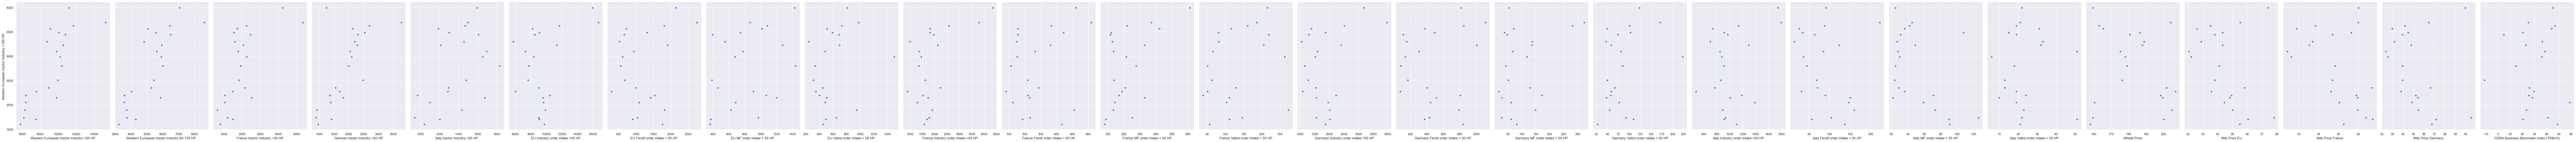

Mean of residuals =>  78.07176846871828


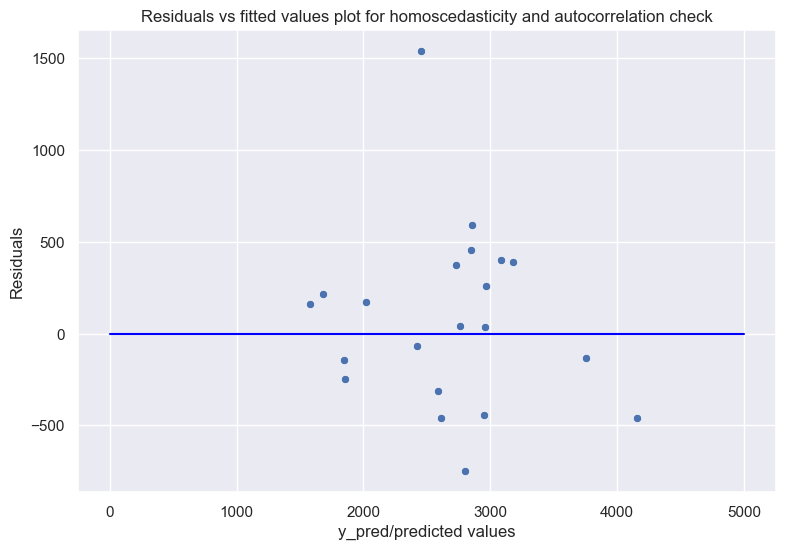

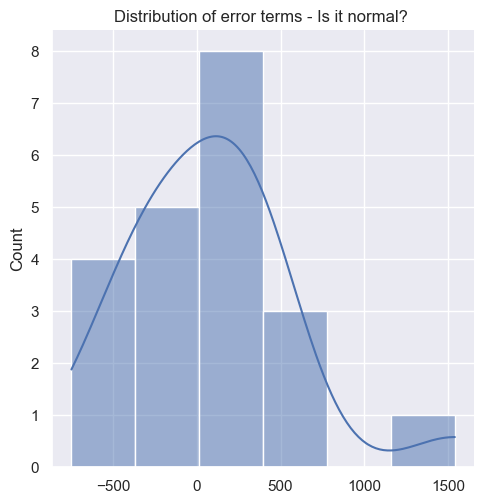

In [380]:
# Check linear model assumptions
train_data = pd.concat([X_test, y_test], axis = 1)
x_vars = train_data.columns.tolist()[:-1]
y_vars = train_data.columns.tolist()[-1]
check_linear_model_assumptions(y_test.reset_index(drop=True).squeeze(), preds_lasso, train_data, x_vars, y_vars)

#### Assumptions of a linear model don't hold true. I could try to use transformations to improve the model performance but it's very unlikely that the linear model is a good choice for this problem. To include seasonality in the linear model, I tried to use sine cosine functions as features but that didn't help much. So, I decided not to include it in the final submission. Finally, moving on to the fbprophet model 

## Approach 4 - Multivariate time series forecasting using Facebook Prophet

In [381]:
# Format dataset to match the requirements of Prophet library
dataset_Prophet = dataset.drop(['Month', 'Year'], axis = 1).rename(columns={'Month_Year': 'ds', 'Western European tractor industry >160 HP ': 'y'})
dataset_Prophet.head()

,ds,Western European tractor industry >50 HP,Western European tractor industry 80-159 HP,y,France tractor industry >50 HP,German tractor industry >50 HP,Italy tractor industry >50 HP,EU Industry order intake >50 HP,EU Fendt order intake > 50 HP,EU MF order intake > 50 HP,...,Germany Valtra order intake > 50 HP,Italy Industry order intake >50 HP,Italy Fendt order intake > 50 HP,Italy MF order intake > 50 HP,Italy Valtra order intake > 50 HP,Wheat Price,Milk Price EU,Milk Price France,Milk Price Germany,CEMA Business Barometer Index (TR&HV)
0,2010-01-01,6187,3731,1407,1425,711,1262,7459.0,1178.0,491.0,...,23.0,928.0,90.0,15.0,6.0,127.60,28.94,30.99,28.40,-51.6
1,2010-02-01,6573,4039,1561,1282,949,1398,9634.0,997.0,761.0,...,24.0,1435.0,71.0,34.0,8.0,124.52,28.63,29.89,28.14,-44.7
2,2010-03-01,11810,6612,3486,1998,2458,1771,11269.0,695.0,1326.0,...,41.0,1525.0,80.0,61.0,17.0,122.41,28.13,28.40,27.95,-35.9
3,2010-04-01,10354,6026,2911,1547,2333,1537,10124.0,945.0,930.0,...,52.0,1450.0,92.0,44.0,16.0,128.81,28.18,27.67,28.37,-26.8
4,2010-05-01,9686,5835,2256,1307,2172,2027,8584.0,954.0,680.0,...,34.0,1202.0,94.0,47.0,7.0,134.31,28.73,27.85,29.41,-13.9


In [382]:
cols = dataset_Prophet.columns.tolist()
cols.remove('ds')
cols.remove('y')

# Modeling
Prophet_model = Prophet(interval_width=0.9)
for col in cols:
    Prophet_model.add_regressor(col, standardize=False)
Prophet_model.fit(dataset_Prophet, iter = 100000)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.96727


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       3.71089    2.7548e-05       4862.07           1           1     1313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1999       10.9863   0.000252635       9707.04      0.5779      0.5779     2585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2999       18.0977   0.000885845       9351.47           1           1     4018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    3999       27.6835   6.00459e-05       3644.12      0.4855      0.4855     5279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    4999       30.3886   6.80169e-06       3757.97      0.3771      0.3771     6558   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    5999     

In [383]:
# Walk-forward cross validation with FBProphet
cutoffs = pd.date_range(start = '2017-08-01', end = '2019-06-01', freq='MS')
df_cv = cross_validation(Prophet_model, horizon='31 days', cutoffs=cutoffs)

  0%|          | 0/23 [00:00<?, ?it/s]


Initial log joint probability = -185.082
Iteration  1. Log joint probability =    62.1555. Improved by 247.237.
Iteration  2. Log joint probability =    124.705. Improved by 62.5493.
Iteration  3. Log joint probability =    131.021. Improved by 6.31634.
Iteration  4. Log joint probability =    182.271. Improved by 51.2503.
Iteration  5. Log joint probability =    256.758. Improved by 74.4862.
Iteration  6. Log joint probability =    306.922. Improved by 50.1641.
Iteration  7. Log joint probability =    315.129. Improved by 8.20706.
Iteration  8. Log joint probability =    315.167. Improved by 0.0385337.
Iteration  9. Log joint probability =    315.347. Improved by 0.180156.
Iteration 10. Log joint probability =     315.38. Improved by 0.0325273.
Iteration 11. Log joint probability =    315.402. Improved by 0.0224052.
Iteration 12. Log joint probability =    315.447. Improved by 0.0448907.
Iteration 13. Log joint probability =    315.543. Improved by 0.0954637.
Iteration 14. Log joint 

In [384]:
# Results using fbprophet
display(performance_metrics(df_cv).loc[2, ['rmse', 'mape']])
plot_results(df_cv['yhat'], title = 'FBProphet with walk-forward cross validation', method_name='FBProphet')

rmse    231.437763
mape      0.081598
Name: 2, dtype: object

#### fbprophet model with walk-forward cross validation outperforms all the other models - RMSE of ~231 and MAPE of ~8%

## Future work

#### 1) Carefully engineer new features (after a disscussion with domain experts) to improve model performance
#### 2) Hyperparameter tuning or trying a different combination of one of above approaches - for example,
##### &nbsp;&nbsp;&nbsp;&nbsp;i) fbprohet doesn't support exogenous variables but there's a way around to implement the same. 
##### &nbsp;&nbsp;&nbsp;&nbsp;ii) VARMAX doesn't support seasonality but there's a way around to implement the same.